                           ┌──────────────────────────┐
                           │          START           │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Import libraries & setup │
                           │ (device, warnings, etc.) │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Define network & replay  │
                           │ buffer classes           │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Parse arguments (mode,   │
                           │ env, steps, buffer type) │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Initialize environment   │
                           │ (single or vectorized)   │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Create policy network    │
                           │ & optimizer              │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Initialize replay buffer │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │ Start profiling (time &  │
                           │ memory tracking)         │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                 ┌───────────────────────────────────────────┐
                 │             TRAINING LOOP                 │
                 └─────────────┬─────────────────────────────┘
                               │
                               ▼
        ┌──────────────────────────────────────────────────────┐
        │ - Get state / observations                           │
        │ - Select action from policy                          │
        │ - Step environment → next state, reward, done        │
        │ - Store transition in replay buffer                  │
        │ - If enough samples: sample batch → update network   │
        │ - Log episode reward if done                         │
        │ - Record timings & memory usage                      │
        └──────────────────────────────────────────────────────┘
                               │
                               ▼
                           ┌──────────────────────────┐
                           │ End training: close envs │
                           │ stop profiling, save CSV │
                           └─────────────┬────────────┘
                                         │
                                         ▼
                           ┌──────────────────────────┐
                           │           END            │
                           └──────────────────────────┘



In [ ]:
import time
import tracemalloc
import csv
import argparse
import multiprocessing as mp
import sys
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from collections import deque
import random

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Global device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



#!!!!!!!!!!!!!!!!  MODEL !!!!!!!!!!!!!

class PolicyNetwork(nn.Module):
    """Simple feedforward policy network for discrete action spaces."""

    def __init__(self, input_dim, output_dim, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)



#!!!!!!!!!!!!!!!!  REPLAY BUFFERS  !!!!!!!!!!!!!!

class SimpleReplay:
    """Basic replay buffer using Python list."""

    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []

    def add(self, obs, action, reward, next_obs, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((obs, action, reward, next_obs, done))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        batch = random.sample(self.buffer, batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)
        return obs, actions, rewards, next_obs, dones

    def __len__(self):
        return len(self.buffer)


class SimpleDequeReplay:
    """Replay buffer using deque for efficient FIFO operations."""

    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, obs, act, rew, next_obs, done):
        self.buffer.append((obs, act, rew, next_obs, done))

    def sample(self, batch_size, device=DEVICE):
        if len(self.buffer) < batch_size:
            return None

        idx = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in idx]
        obs, acts, rews, next_obs, dones = zip(*batch)

        return (
            torch.tensor(np.array(obs), dtype=torch.float32, device=device),
            torch.tensor(acts, dtype=torch.int64, device=device),
            torch.tensor(rews, dtype=torch.float32, device=device),
            torch.tensor(np.array(next_obs), dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


class PreallocatedReplay:
    """Memory-efficient replay buffer with pre-allocated tensors."""

    def __init__(self, capacity, obs_shape, device="cpu", pin_memory=False):
        self.capacity = capacity
        self.device = device
        self.pos = 0
        self.full = False

        # Pre-allocate buffers
        self.obs_buf = torch.empty((capacity,) + obs_shape, dtype=torch.float32, pin_memory=pin_memory)
        self.next_obs_buf = torch.empty((capacity,) + obs_shape, dtype=torch.float32, pin_memory=pin_memory)
        self.acts_buf = torch.empty(capacity, dtype=torch.int64, pin_memory=pin_memory)
        self.rews_buf = torch.empty(capacity, dtype=torch.float32, pin_memory=pin_memory)
        self.dones_buf = torch.empty(capacity, dtype=torch.float32, pin_memory=pin_memory)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.pos].copy_(torch.as_tensor(obs, dtype=torch.float32))
        self.next_obs_buf[self.pos].copy_(torch.as_tensor(next_obs, dtype=torch.float32))
        self.acts_buf[self.pos] = act
        self.rews_buf[self.pos] = rew
        self.dones_buf[self.pos] = done

        self.pos = (self.pos + 1) % self.capacity
        if self.pos == 0:
            self.full = True

    def sample(self, batch_size, device=DEVICE):
        max_idx = self.capacity if self.full else self.pos
        if max_idx < batch_size:
            return None

        idx = torch.randint(0, max_idx, (batch_size,))
        return (
            self.obs_buf[idx].to(device, non_blocking=True),
            self.acts_buf[idx].to(device, non_blocking=True),
            self.rews_buf[idx].to(device, non_blocking=True),
            self.next_obs_buf[idx].to(device, non_blocking=True),
            self.dones_buf[idx].to(device, non_blocking=True),
        )

    def __len__(self):
        return self.capacity if self.full else self.pos



# !!!!!!!!!!!!!!!!!!  TRAINING LOOPS  1!!!!!!!!!!!!!!!!

def train_baseline(env_name, steps, out_csv, buffer_type="simple"):
    """Train a single agent with profiling."""

    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    policy = PolicyNetwork(obs_dim, act_dim).to(DEVICE)
    optim = torch.optim.Adam(policy.parameters(), lr=1e-3)

    # Choose replay buffer type
    if buffer_type == "simple":
        replay = SimpleReplay(capacity=10000)
    elif buffer_type == "deque":
        replay = SimpleDequeReplay(capacity=10000)
    elif buffer_type == "preallocated":
        replay = PreallocatedReplay(capacity=10000, obs_shape=(obs_dim,))
    else:
        raise ValueError(f"Unknown buffer type: {buffer_type}")

    obs, _ = env.reset()
    obs = np.array(obs, dtype=np.float32)

    tracemalloc.start()
    episode_rewards = []
    current_episode_reward = 0

    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "env_time", "forward_time", "learn_time", "reward", "episode_reward", "mem_kb"])

        for step in range(steps):
            t0 = time.perf_counter()

            # Convert to tensor and get action
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)

            with torch.no_grad():
                logits = policy(obs_tensor)
                action = torch.argmax(logits, dim=1).item()

            t1 = time.perf_counter()
            forward_time = t1 - t0

            # Step environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            current_episode_reward += reward

            # Add to replay buffer
            replay.add(obs, action, reward, next_obs, done)

            # Reset if done
            if done:
                episode_rewards.append(current_episode_reward)
                current_episode_reward = 0
                obs, _ = env.reset()
                obs = np.array(obs, dtype=np.float32)
            else:
                obs = np.array(next_obs, dtype=np.float32)

            t2 = time.perf_counter()
            env_time = t2 - t1

            # Learning step
            learn_time = 0
            if len(replay) >= 32:
                t_learn_start = time.perf_counter()

                if buffer_type in ["deque", "preallocated"]:
                    batch = replay.sample(32, device=DEVICE)
                    if batch is not None:
                        ob, ac, rw, nobs, dn = batch

                        # Simple Q-learning update
                        logits = policy(ob)
                        pred = logits.gather(1, ac.unsqueeze(1)).squeeze()

                        with torch.no_grad():
                            next_values = policy(nobs).max(dim=1)[0]
                            targets = rw + 0.99 * next_values * (1 - dn)

                        loss = F.mse_loss(pred, targets)

                        optim.zero_grad()
                        loss.backward()
                        optim.step()
                else:  # simple buffer
                    batch = replay.sample(32)
                    if batch is not None:
                        ob, ac, rw, nobs, dn = batch

                        # Convert to tensors
                        ob = torch.tensor(np.array(ob), dtype=torch.float32, device=DEVICE)
                        ac = torch.tensor(ac, dtype=torch.int64, device=DEVICE)
                        rw = torch.tensor(rw, dtype=torch.float32, device=DEVICE)
                        nobs = torch.tensor(np.array(nobs), dtype=torch.float32, device=DEVICE)
                        dn = torch.tensor(dn, dtype=torch.float32, device=DEVICE)

                        # Simple Q-learning update
                        logits = policy(ob)
                        pred = logits.gather(1, ac.unsqueeze(1)).squeeze()

                        with torch.no_grad():
                            next_values = policy(nobs).max(dim=1)[0]
                            targets = rw + 0.99 * next_values * (1 - dn)

                        loss = F.mse_loss(pred, targets)

                        optim.zero_grad()
                        loss.backward()
                        optim.step()

                learn_time = time.perf_counter() - t_learn_start

            # Memory tracking
            current_mem, peak_mem = tracemalloc.get_traced_memory()

            # Calculate average episode reward
            avg_episode_reward = np.mean(episode_rewards[-100:]) if episode_rewards else 0

            writer.writerow([
                step,
                env_time,
                forward_time,
                learn_time,
                reward,
                avg_episode_reward,
                peak_mem // 1024
            ])

    env.close()
    tracemalloc.stop()
    print(f"Training completed. Logs saved to {out_csv}")
    print(f"Final average episode reward (last 100 episodes): {avg_episode_reward:.2f}")


def train_vectorized(env_name, steps, num_envs, out_csv, buffer_type="deque"):
    """Train with vectorized environments for better throughput."""

    from gymnasium.vector import SyncVectorEnv

    envs = SyncVectorEnv([lambda: gym.make(env_name) for _ in range(num_envs)])
    obs_dim = envs.single_observation_space.shape[0]
    act_dim = envs.single_action_space.n

    policy = PolicyNetwork(obs_dim, act_dim).to(DEVICE)
    optim = torch.optim.Adam(policy.parameters(), lr=1e-3)

    # Choose replay buffer type
    if buffer_type == "deque":
        replay = SimpleDequeReplay(capacity=10000)
    elif buffer_type == "preallocated":
        replay = PreallocatedReplay(capacity=10000, obs_shape=(obs_dim,))
    else:
        replay = SimpleDequeReplay(capacity=10000)

    obs, _ = envs.reset()
    tracemalloc.start()

    episode_rewards = [0.0] * num_envs
    completed_episodes = []

    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "env_time", "forward_time", "learn_time", "mean_reward", "avg_episode_reward", "mem_kb"])

        for step in range(steps):
            t0 = time.perf_counter()

            # Get actions
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
            with torch.no_grad():
                logits = policy(obs_tensor)
                actions = torch.argmax(logits, dim=1).cpu().numpy()

            t1 = time.perf_counter()
            forward_time = t1 - t0

            # Step environments
            next_obs, rewards, terminateds, truncateds, _ = envs.step(actions)
            dones = np.logical_or(terminateds, truncateds)

            # Track episode rewards
            for i in range(num_envs):
                episode_rewards[i] += rewards[i]
                if dones[i]:
                    completed_episodes.append(episode_rewards[i])
                    episode_rewards[i] = 0.0

            # Add to replay buffer
            for i in range(num_envs):
                replay.add(obs[i], actions[i], rewards[i], next_obs[i], dones[i])

            obs = next_obs
            t2 = time.perf_counter()
            env_time = t2 - t1

            # Learning step
            learn_time = 0
            if len(replay) >= 32:
                t_learn_start = time.perf_counter()
                batch = replay.sample(32, device=DEVICE)

                if batch is not None:
                    ob, ac, rw, nobs, dn = batch

                    # Simple Q-learning update
                    logits = policy(ob)
                    pred = logits.gather(1, ac.unsqueeze(1)).squeeze()

                    with torch.no_grad():
                        next_values = policy(nobs).max(dim=1)[0]
                        targets = rw + 0.99 * next_values * (1 - dn)

                    loss = F.mse_loss(pred, targets)

                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                learn_time = time.perf_counter() - t_learn_start

            # Memory tracking
            current_mem, peak_mem = tracemalloc.get_traced_memory()

            # Calculate average episode reward
            avg_episode_reward = np.mean(completed_episodes[-100:]) if completed_episodes else 0

            writer.writerow([
                step,
                env_time,
                forward_time,
                learn_time,
                np.mean(rewards),
                avg_episode_reward,
                peak_mem // 1024
            ])

    envs.close()
    tracemalloc.stop()
    print(f"Vectorized training completed. Logs saved to {out_csv}")
    print(f"Final average episode reward (last 100 episodes): {avg_episode_reward:.2f}")



# !!!!!!!!!!!!!!!!! ENTRY POINT  !!!!!!!!!!!

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="RL Training with Profiling")
    parser.add_argument("--mode", choices=["baseline", "vectorized"], default="baseline",
                        help="Training mode: baseline (single env) or vectorized (multiple envs)")
    parser.add_argument("--env", type=str, default="CartPole-v1",
                        help="Gymnasium environment name")
    parser.add_argument("--steps", type=int, default=1000,
                        help="Number of training steps")
    parser.add_argument("--num_envs", type=int, default=4,
                        help="Number of parallel environments for vectorized mode")
    parser.add_argument("--buffer", choices=["simple", "deque", "preallocated"], default="deque",
                        help="Replay buffer type")
    parser.add_argument("--out", type=str, default="training_log.csv",
                        help="Output CSV file for profiling data")

    args,unknown = parser.parse_known_args()

    print(f"Starting training with {args.mode} mode on {args.env}")
    print(f"Device: {DEVICE}")
    print(f"Buffer type: {args.buffer}")

    if args.mode == "baseline":
        train_baseline(args.env, args.steps, args.out, args.buffer)
    elif args.mode == "vectorized":
        train_vectorized(args.env, args.steps, args.num_envs, args.out, args.buffer)

Starting training with baseline mode on CartPole-v1
Device: cpu
Buffer type: deque
Training completed. Logs saved to training_log.csv
Final average episode reward (last 100 episodes): 9.41


plotting the graphs!!!!


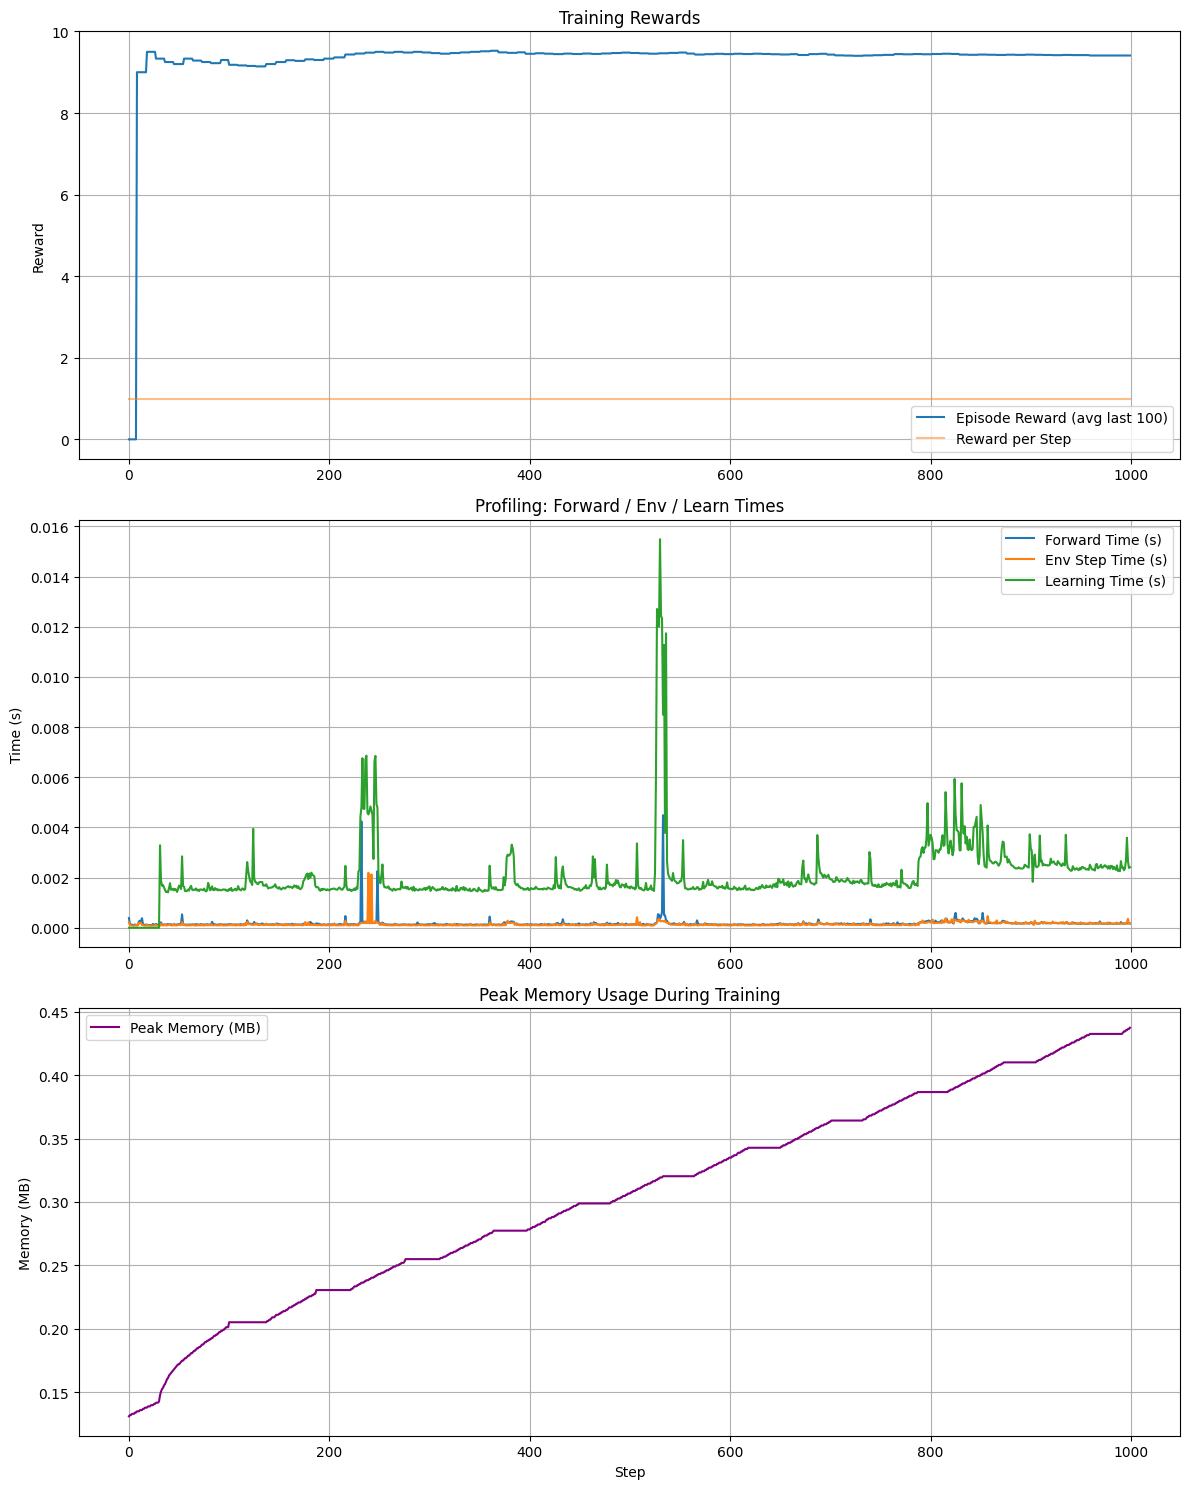

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("training_log.csv")

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

#Rewards
axes[0].plot(df["step"], df["episode_reward"], label="Episode Reward (avg last 100)")
axes[0].plot(df["step"], df["reward"], alpha=0.5, label="Reward per Step")
axes[0].set_ylabel("Reward")
axes[0].set_title("Training Rewards")
axes[0].legend()
axes[0].grid(True)

# Profiling Times
axes[1].plot(df["step"], df["forward_time"], label="Forward Time (s)")
axes[1].plot(df["step"], df["env_time"], label="Env Step Time (s)")
axes[1].plot(df["step"], df["learn_time"], label="Learning Time (s)")
axes[1].set_ylabel("Time (s)")
axes[1].set_title("Profiling: Forward / Env / Learn Times")
axes[1].legend()
axes[1].grid(True)

# Memory Usage
axes[2].plot(df["step"], df["mem_kb"]/1024, label="Peak Memory (MB)", color='purple')
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Memory (MB)")
axes[2].set_title("Peak Memory Usage During Training")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Configuration
ENV_NAME = "CartPole-v1"
STEPS = 1000
NUM_ENVS = 4
BUFFER_TYPE = "deque"

#  Run baseline training

print("Starting baseline training...")
train_baseline(
    env_name=ENV_NAME,
    steps=STEPS,
    out_csv="training_baseline.csv",
    buffer_type=BUFFER_TYPE
)
print("Baseline training done. CSV saved as training_baseline.csv\n")

# Run vectorized training

print("Starting vectorized training...")
train_vectorized(
    env_name=ENV_NAME,
    steps=STEPS,
    num_envs=NUM_ENVS,
    out_csv="training_vectorized.csv",
    buffer_type=BUFFER_TYPE
)
print("Vectorized training done. CSV saved as training_vectorized.csv\n")

#Verify files
import os
print("Current files:", os.listdir())


Starting baseline training...
Training completed. Logs saved to training_baseline.csv
Final average episode reward (last 100 episodes): 9.50
Baseline training done. CSV saved as training_baseline.csv

Starting vectorized training...
Vectorized training completed. Logs saved to training_vectorized.csv
Final average episode reward (last 100 episodes): 9.23
Vectorized training done. CSV saved as training_vectorized.csv

Current files: ['.config', 'training_vectorized.csv', 'training_baseline.csv', 'training_log.csv', 'sample_data']
